In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
class Integrator():
    
    def __init__(self,f, h):
        self.function = f
        self.h = h
        self.times = None
        self.qs = None
        self.ps = None
    
    def step(self, t, q, p):
        q,p = self.function(q,p)
        return t, q, p
    
    def integrate(self, interval, q, p):
        t = interval[0]
        t_fin = interval[1]
        
        self.times = [t]
        self.qs = [np.array(q)]
        self.ps = [np.array(p)]        

        while t<t_fin:
            t, q, p = self.step(t, q, p)
            self.times.append(t)
            self.qs.append(np.array(q))
            self.ps.append(np.array(p))

    def plot_orbit(self,n):
        plot_q = [element[n] for element in self.qs]
        plot_p = [element[n] for element in self.ps]           
        
        plt.plot(plot_p,plot_q)
        plt.gca().axis('equal')   

In [3]:
   
class SymplecticEuler(Integrator):
    
    def step(self, t, q, p):
        
        q = np.array(q)
        p = np.array(p)
        
        Q, P = self.function(q,p)
        
        p = p + self.h*np.array(P)
        
        Q, P = self.function(q,p)
        
        q = q + self.h*np.array(Q)
        
        t = t+self.h
        
        return t, q, p

In [4]:
class ForwardEuler(Integrator):
    
    def step(self, t, q, p):
        
        q = np.array(q)
        p = np.array(p)
        
        Q, P = self.function(q,p)
        
        p = p + self.h*np.array(P)
                
        q = q + self.h*np.array(Q)
        
        t = t+self.h
        
        return t, q, p

In [5]:
class RungeKutta4(Integrator):
    
    def step(self, t, q, p):
        
        q = np.array(q)
        p = np.array(p)

        Q1, P1 = self.function(q,p)
        
        Q2, P2 = self.function(q+np.array(Q1)*self.h/2, p + np.array(P1)*self.h/2)
        
        Q3, P3 = self.function(q+np.array(Q2)*self.h/2, p + np.array(P2)*self.h/2)
        
        Q4, P4 = self.function(q+np.array(Q3)*self.h, p + np.array(P3)*self.h)
        
        q = q + 1/6*self.h*(np.array(Q1) + 2*np.array(Q2) + np.array(Q3) +np.array(Q4))

        p = p + 1/6*self.h*(np.array(P1) + 2*np.array(P2) + np.array(P3) + np.array(P4))

        t = t + self.h

        return t, q, p

In [6]:
class SymplecticOrder4(Integrator):
    
    def __init__(self, h, function):
        self.h = h
        self.function = function

        # precalculate constants
        self.c1 = 1/(2*(2-2**(1/3)))
        self.c4 = self.c1
        self.c2 = (1 - 2**(1/3))/(2*(2-2**(1/3)))
        self.c3 = self.c2
        self.d1 = 1/((2-2**(1/3)))
        self.d3 = self.d1
        self.d2 = ( - 2**(1/3))/(2-2**(1/3))
        
    def step(self, t, q, p):

        q = np.array(q)
        p = np.array(p)

        q = self.Q_step(self.c4, q, p)
        p = self.P_step(self.d3, q, p)
        q = self.Q_step(self.c3, q, p)
        p = self.P_step(self.d2, q, p)
        q = self.Q_step(self.c2, q, p)
        p = self.P_step(self.d1, q, p)
        q = self.Q_step(self.c1, q, p)

        t += self.h
        return t, q, p
    
    def Q_step(self, c, q, p):
        
        Q, _ = self.function(q, p)
        return q + [self.h*c*q_i for q_i in Q]
    
    def P_step(self, d, q, p):
        _, P = self.function(q, p)
        return p + [self.h*d*p_i for p_i in P]
    


In [7]:
class AdamsBashforth4(Integrator):
    
    def __init__(self, f, h):
        super().__init__(f, h)
        self.previous_f = []
    
    def step(self, t, q, p):
        
        Q, P = self.function(q, p)
        
        if len(self.previous_f) < 3:
            self.previous_f.append((Q, P))
            q_new = np.array(q) + self.h * np.array(Q)
            p_new = np.array(p) + self.h * np.array(P)
        else:
            q_new = np.array(q) + self.h / 24 * (55 * np.array(self.previous_f[-1][0]) - 59 * np.array(self.previous_f[-2][0]) + 37 * np.array(self.previous_f[-3][0]) - 9 * np.array(Q))
            p_new = np.array(p) + self.h / 24 * (55 * np.array(self.previous_f[-1][1]) - 59 * np.array(self.previous_f[-2][1]) + 37 * np.array(self.previous_f[-3][1]) - 9 * np.array(P))
            
            # Update the previous_f list
            self.previous_f.pop(0)
            self.previous_f.append((Q, P))
        
        t += self.h
        return t, q_new.tolist(), p_new.tolist()

In [8]:
def hoscillator(q,p):
    q = np.array(q)
    p = np.array(p)

    q_out = p
    p_out = -q
    
    return q_out, p_out

In [10]:
adams4 = AdamsBashforth4(hoscillator,0.1)

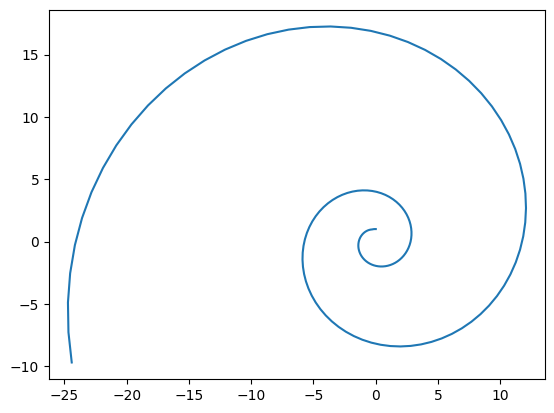

In [11]:
adams4.integrate([0,5*np.pi],[1,1],[0,0])
adams4.plot_orbit(0)

plt.show()

In [20]:
from scipy.integrate import solve_ivp
class ZVODEIntegrator(Integrator):
    
    def integrate(self, interval, q, p):
        t_span = interval
        y0 = np.array(q + p)  # Combining q and p as initial conditions

        # The ZVODE method is accessed via 'BDF' method in solve_ivp
        sol = solve_ivp(self.ode_system, t_span, y0, method='BDF', t_eval=np.arange(t_span[0], t_span[1] + self.h, self.h))

        n = len(q)
        self.times = sol.t.tolist()
        self.qs = [list(y[:n]) for y in sol.y.T]
        self.ps = [list(y[n:]) for y in sol.y.T]

    def ode_system(self, t, y):
        n = len(y) // 2
        q, p = y[:n], y[n:]
        Q, P = self.function(q, p)
        return Q + P  # returning derivatives for both q and p

In [12]:
forweuler = ForwardEuler(hoscillator,0.1)

In [13]:

forweuler.integrate([0,5*np.pi],[1, 1],[0, 0])

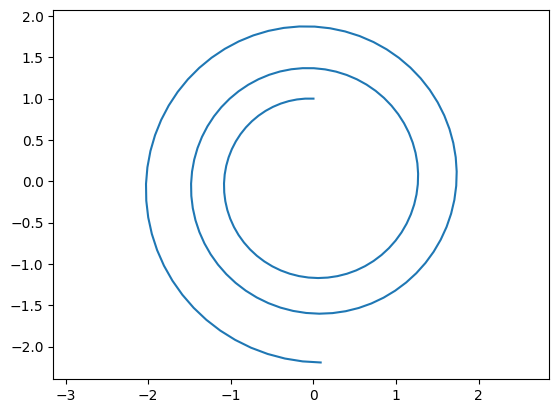

In [14]:
forweuler.plot_orbit(1)

In [15]:
rk4 = RungeKutta4(hoscillator,0.1)


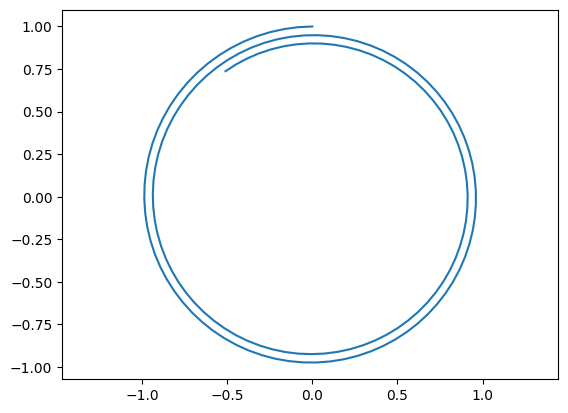

In [16]:
rk4.h = 0.1

rk4.integrate([0,5*np.pi],[1, 1],[0, 0])

rk4.plot_orbit(0)

In [17]:
sympO4 = SymplecticOrder4(0.1, hoscillator)


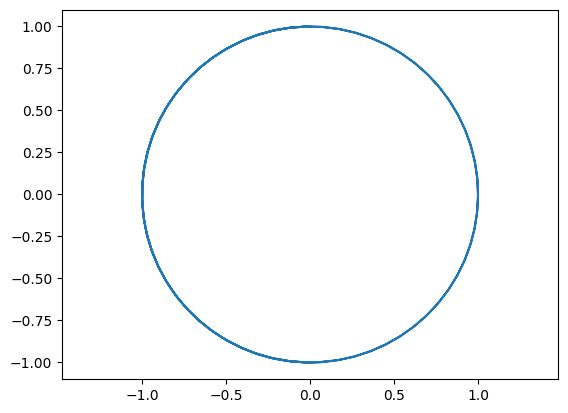

In [18]:
sympO4.h = 0.1

sympO4.integrate([0,5*np.pi],[1,1],[0,0])

sympO4.plot_orbit(0)

In [19]:
plt.plot(test.qs, test.ps)

NameError: name 'test' is not defined

In [ ]:
t, q, p = 0, 1, 0

solution = []

for i in range(10):

    t, q, p = test.step(t, q, p)
    
    solution.append((t ,q, p))
    
    

In [ ]:
solution

In [31]:
mat = np.array([[1, 2, 3],[1,2,3]])
print(mat)
mat2 = np.array(mat)
print(mat2)
np.array_equal(mat,mat2)


[[1 2 3]
 [1 2 3]]
[[1 2 3]
 [1 2 3]]


True